# Environment Set-Up

In [1]:
import os
import pickle
import time
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.__version__)
print(np.__version__)
print(plotly.__version__)

2.1.0
1.19.4
4.12.0


# Load MNIST

Source: https://www.tensorflow.org/tutorials/quickstart/beginner

Source: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [3]:
# Prepare the training dataset.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# training_size
training_size = x_train.shape[0]

print(x_train.shape)

(50000, 784)


# Specify Model

Source: S7 Additional details on model architectures and training hyperparameters

Deciations: 'glorot_uniform' initialization instead of 'He-normal' initialization

In [4]:
# architecture
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(100, activation="relu", kernel_initializer='glorot_uniform')(inputs)
x2 = layers.Dense(50, activation="relu", kernel_initializer='glorot_uniform')(x1)
outputs = layers.Dense(10, name="predictions", kernel_initializer='glorot_uniform')(x2)
model = keras.Model(inputs=inputs, outputs=outputs)
num_params = (784*100 + 100 + 100*50 + 50 + 50*10 + 10)
# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# Doesn't seem to work
# optimizer = tf.keras.optimizers.SGD(
#     learning_rate=0.01, momentum=.01,
#     name='SGD'
# )

# Training + Collect LCA

## Initialize Tracking Metrics

In [5]:
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

training_loss_metric = tf.keras.metrics.Mean()
training_loss_list = []
train_acc_list = []
val_acc_list = []
step_loss_list = []

# Store weights as rows in # iterations x # parameter matrix
step_parameters_over_time = []

# store grads as rows in # iterations x # parameter matrix
step_grads_over_time = []

## Specify Training Parameters

In [6]:
# num epochs, paper says they train for 4 epochs and each epoch is 220 steps
epochs = 4
# batch_size
batch_size = training_size // 220
# batch_size = training_size // 880

print(batch_size)

227


## Training Loop + Store LCA Inputs

In [7]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=training_size).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

training_start = time.time()
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    


    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        # Store weights at start of step
        step_weights = np.array([])
        for layer in model.weights:
            layer_weights = np.copy(layer.numpy())
            # flatten weights 
            layer_weights = layer_weights.flatten()
            # add to iteration weight
            step_weights = np.concatenate([step_weights, layer_weights], axis=0)
        assert step_weights.shape[0] == num_params
        step_parameters_over_time.append(step_weights)
        
        ## TAKE GRADIENT STEP BASED ON MINIBATCH
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        # Update loss metric.
        training_loss_metric.update_state(loss_value)
        
        # Log every 20 batches.
        if step % 20 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
        
        ## RECORD GRADIENT ON FULL TRAINING SET FOR LCA
        with tf.GradientTape() as full_tape:
            # Run the forward pass of the layer on the entire training set
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            full_logits = model(x_train, training=False)
            # Compute the loss value on the entire training set.
            full_loss_value = loss_fn(y_train, full_logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        full_grads = full_tape.gradient(full_loss_value, model.trainable_weights)
        
        # save full training loss
        step_loss_list.append(np.copy(full_loss_value.numpy()))
        # save full training loss gradient
        step_grads = np.array([])
        # assumes grads are being concatenated in same order as weights,
        # otherwise LCA will be wrongly allocated
        for layer in full_grads:
            layer_grads = np.copy(layer)
            # flatten weights 
            layer_grads = layer_grads.flatten()
            # add to iteration weight
            step_grads = np.concatenate([step_grads, layer_grads], axis=0)
        assert step_grads.shape[0] == num_params
        step_grads_over_time.append(step_grads)
    
    # Display metrics at the end of each epoch and add to list
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    train_acc_list.append(train_acc)
    # save training loss to list
    training_loss_result = training_loss_metric.result()
    training_loss_list.append(training_loss_result)
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    training_loss_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_list.append(val_acc)
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

training_end = time.time()

print(training_end - training_start)


Start of epoch 0
Training loss (for one batch) at step 0: 109.1941
Seen so far: 227 samples
Training loss (for one batch) at step 20: 4.5395
Seen so far: 4767 samples
Training loss (for one batch) at step 40: 2.2323
Seen so far: 9307 samples
Training loss (for one batch) at step 60: 1.9227
Seen so far: 13847 samples
Training loss (for one batch) at step 80: 1.1157
Seen so far: 18387 samples
Training loss (for one batch) at step 100: 2.0926
Seen so far: 22927 samples
Training loss (for one batch) at step 120: 1.8691
Seen so far: 27467 samples
Training loss (for one batch) at step 140: 0.9959
Seen so far: 32007 samples
Training loss (for one batch) at step 160: 0.5051
Seen so far: 36547 samples
Training loss (for one batch) at step 180: 1.1958
Seen so far: 41087 samples
Training loss (for one batch) at step 200: 1.4684
Seen so far: 45627 samples
Training loss (for one batch) at step 220: 0.8393
Seen so far: 50167 samples
Training acc over epoch: 0.8301
Validation acc: 0.9031
Time taken:

## Create LCAs

In [8]:
# at each training iteration, save all parameters as a 1D vector theta_t for iteration t
# also save the loss at each iteration L(theta_t)
# next for each (iteration -1), take the difference: L(theta_t1) - L(theta_t0)
# we can approximate this difference with the dot product via Taylor approximation
# i.e. L(theta_t1) - L(theta_t0) = << gradient of loss w.r.t theta, theta_t1 - theta_t0 >>

#next decompose dot product into its summands i.e. at time t, 
# sigma_i ([gradient of loss w.r.t theta] i) * ([theta_t1]_i - [theta_t0]_i)
# call each : ([gradient of loss w.r.t theta] i) * ([theta_t1]_i - [theta_t0]_i) the LCA of i at t

num_steps = len(step_parameters_over_time)
step_lcas_over_time = []
for i in range(num_steps - 1):
    theta_t0 = step_parameters_over_time[i]
    theta_t1 = step_parameters_over_time[i+1]
    delta_theta = theta_t1 - theta_t0
    grad_theta = step_grads_over_time[i]
    summands = grad_theta * delta_theta
    step_lcas_over_time.append(summands)
    
print(len(step_lcas_over_time))
step_lcas_over_time = np.stack(step_lcas_over_time)
print(step_lcas_over_time.shape)

883
(883, 84060)


## Save LCAs

In [9]:
with open('../data/experiment_1/lcas_run_1.pickle', 'wb') as f:
    pickle.dump(step_lcas_over_time, f)

# Evaluation

## Read LCAs (Optional)

In [10]:
## Save LCAs
with open('../data/experiment_1/lcas_run_1.pickle', 'rb') as f:
    step_lcas_over_time = pickle.load(f)

## Plot Train/Val  Accuracy and Loss

Text(0.5, 0, 'Epoch')

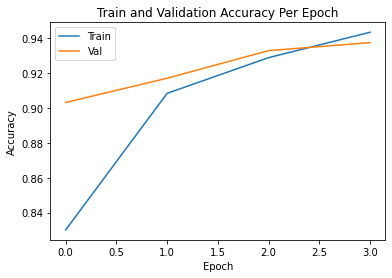

In [11]:
plt.plot(train_acc_list,label='Train')
plt.plot(val_acc_list,label='Val')
plt.legend()
plt.title("Train and Validation Accuracy Per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

Text(0.5, 0, 'Step')

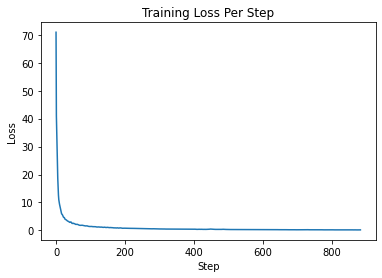

In [12]:
plt.plot(step_loss_list)
plt.title("Training Loss Per Step")
plt.ylabel("Loss")
plt.xlabel("Step")

## Plot delta in training loss compared to Taylor approximation of delta on the step losses

Text(0.5, 0, 'Step')

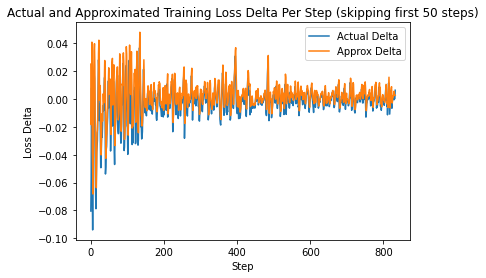

In [13]:
skip_step = 50
training_loss_delta = (np.array(step_loss_list)[1:] - np.array(step_loss_list)[:-1])[skip_step:]
training_loss_delta_approximation = step_lcas_over_time.sum(1)[skip_step:]
plt.plot(training_loss_delta,label='Actual Delta')
plt.plot(training_loss_delta_approximation,label='Approx Delta')
plt.legend()
plt.title("Actual and Approximated Training Loss Delta Per Step (skipping first 50 steps)")
plt.ylabel("Loss Delta")
plt.xlabel("Step")

In [14]:
# approximation is highly correlated
np.corrcoef(training_loss_delta, training_loss_delta_approximation)

array([[1.        , 0.68654739],
       [0.68654739, 1.        ]])

## Categorize LCAs

In [15]:
def categorize_lca(lca, tol=.0, zero_cat=1):
    category = 0
    if lca == 0:
        category = zero_cat
    elif lca > 0:
        category = 2
    return category

pd.Series(step_lcas_over_time.flatten()).apply(lambda x :categorize_lca(x)).value_counts(normalize=True)

1    0.423059
0    0.306956
2    0.269985
dtype: float64

Text(0, 0.5, '# of LCAs')

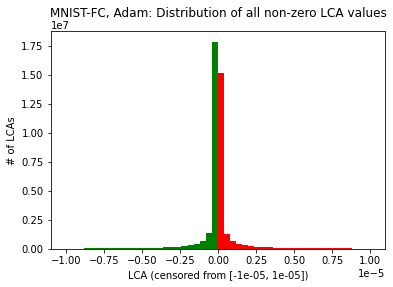

In [16]:
hist_range = np.quantile(step_lcas_over_time.flatten(),.01), np.quantile(step_lcas_over_time.flatten(),.99)
hist_range = [-1e-5, 1e-5]
plt.hist(step_lcas_over_time.flatten()[step_lcas_over_time.flatten() <0], bins=50, range=hist_range,color='green')
plt.hist(step_lcas_over_time.flatten()[step_lcas_over_time.flatten() >0], bins=50, range=hist_range,color='red')

plt.title('MNIST-FC, Adam: Distribution of all non-zero LCA values',y=1.04)
plt.xlabel(f'LCA (censored from {hist_range})')
plt.ylabel(f'# of LCAs')

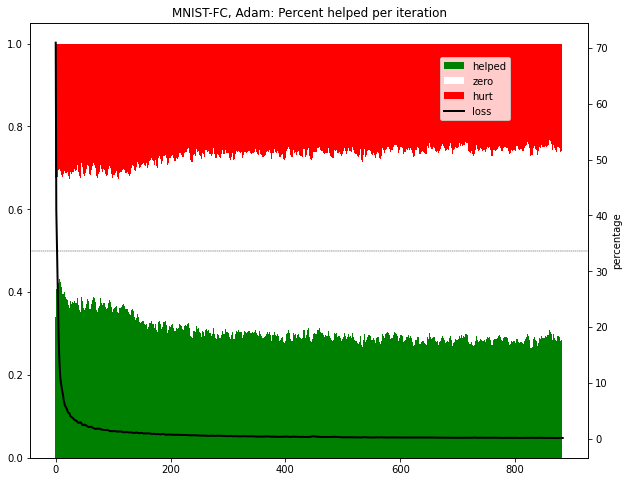

In [17]:
num_steps = step_lcas_over_time.shape[0]
num_weights = step_lcas_over_time.shape[1]
pct_positive_lcas_per_step = np.apply_along_axis(lambda x : (x>0).sum(), 1, step_lcas_over_time) / num_weights  
pct_zero_lcas_per_step = np.apply_along_axis(lambda x : (x==0).sum(), 1, step_lcas_over_time) / num_weights 
pct_negative_lcas_per_step = np.apply_along_axis(lambda x : (x<0).sum(), 1, step_lcas_over_time) / num_weights
ind = np.arange(num_steps)    # the x locations for the groups
width = 1

fig, ax1 = plt.subplots(figsize=(10,8))

p1 = ax1.bar(ind, pct_negative_lcas_per_step, width, bottom=0, color='green', label='helped')
p2 = ax1.bar(ind, pct_zero_lcas_per_step, width, bottom=pct_negative_lcas_per_step, color='white', label='zero')
p3 = ax1.bar(ind, pct_positive_lcas_per_step, width, bottom=pct_negative_lcas_per_step+pct_zero_lcas_per_step, color='red', label='hurt')
ax1.axhline(y=.5, xmin=0, xmax=num_steps, c='black',lw=.4,linestyle='--')

ax2 = ax1.twinx()
p0 = ax2.plot(step_loss_list, c='black',lw=2, label='loss')

plt.ylabel('percentage')
plt.title('MNIST-FC, Adam: Percent helped per iteration')
fig.legend(loc=(.7,.75))



## Viz LCA over time

In [18]:
from IPython.display import display
from ipywidgets import widgets

epoch_choice = widgets.IntSlider(value=0, min=0, max=len(step_lcas_over_time)-1)
layer_choice = widgets.Select(
    options=[0, 2, 4],
    value=0,
)

container = widgets.HBox(children=[epoch_choice, layer_choice])



layer_breaks = np.cumsum([78400,100,5000,50, 500,10])

layer_index_shape = dict(zip(
    layer_breaks,
    [layer.numpy().shape for layer in grads]
))

t = 0

def get_formatted_lcas_t(t, viz_layer=0):
    formatted_lcas_t = []
    lcas_t = step_lcas_over_time[t]
    layer_index_start = 0
    for layer_index in layer_breaks:
        layer_index_end = layer_index
        layer_lcas = lcas_t[layer_index_start:layer_index_end]
        layer_lcas = layer_lcas.reshape(layer_index_shape[layer_index])
        formatted_lcas_t.append(layer_lcas)
        layer_index_start = layer_index_end
    return formatted_lcas_t[viz_layer]

lcas_t_viz_layer = get_formatted_lcas_t(t)

fig = go.Figure(data=go.Heatmap(
                    z=lcas_t_viz_layer,
                    zmid=0,
#                     zmax=.001, zmin=-.001,
                    colorscale=['green','white','red'])
               )
interactive_figure = go.FigureWidget(fig)

In [19]:
def response(change):
    lcas_t_viz_layer = get_formatted_lcas_t(epoch_choice.value, viz_layer=layer_choice.value)
    with interactive_figure.batch_update():
        interactive_figure.data[0].z = lcas_t_viz_layer
        
epoch_choice.observe(response, names="value")
layer_choice.observe(response, names="value")


In [20]:
# weights for 1 seem to be highest at begining, compare LCA vs class accuracy over time

widgets.VBox([container,
              interactive_figure])